In [1]:
import cv2,os
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from skimage import io, transform
from skimage.io import imread, imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# debug

In [3]:
# path = data_dir
# folders = os.listdir(path)
# idx = 100

# image_folder = os.path.join(path,folders[idx],'images/')
# mask_folder = os.path.join(path,folders[idx],'masks/')
# image_path = os.path.join(image_folder,os.listdir(image_folder)[0])

        
# mk = np.zeros((256, 256, 1),dtype=bool)  
# for mask in os.listdir(mask_folder):
#     mask = io.imread(os.path.join(mask_folder,mask))
#     mask = np.expand_dims(mask,axis=-1)
#     mk = np.maximum(mk, mask)

    
    
# hist = cv2.calcHist([mk],[0],None,[256],[0,256])

# print(mk.shape)
# # print(hist)
# plt.imshow(mk)

# data for train

In [4]:
batch_size=128
image_size=128

data_dir = "../../Datasets/data-science-bowl-2018/stage1_train/"

In [5]:
get_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
])

In [6]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)

    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3]
        img = transform.resize(img, (image_size,image_size))
        mask = self.get_mask(mask_folder, image_size)

        image = get_transform(img).to(torch.float32)
        mask = get_transform(mask).to(torch.float32)
        
        return (image,mask) 

    def get_mask(self, mask_folder, img_size):
        mask = np.zeros((img_size, img_size, 1),dtype=bool)
        boxes = []
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (img_size, img_size))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
        return mask
        
    def __len__(self):
        return len(self.folders)

len(datas):  670
image:  torch.Size([3, 128, 128])
mask:  torch.Size([1, 128, 128])


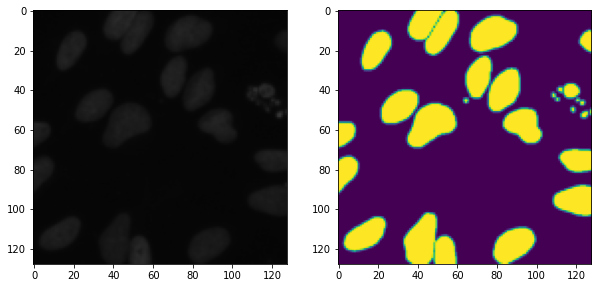

In [7]:
datas = CustomDataset(data_dir)
print("len(datas): ",len(datas))

image, mask = datas[0]
print("image: ",image.shape)
# print(torch.amax(image).item(),torch.amin(image).item())
print("mask: ",mask.shape)
# print(torch.amax(mask).item(),torch.amin(mask).item())

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0))

len(train_data): 536, len(val_data): 134
len(train_loader): 5, len(val_loader): 2
val_imgs.shape: torch.Size([128, 3, 128, 128]), val_masks.shape: torch.Size([128, 1, 128, 128])


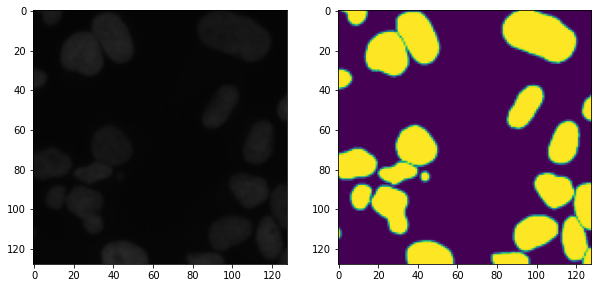

In [8]:
train_len = int(0.8*len(datas))
val_len = len(datas)-train_len
train_data, val_data = torch.utils.data.random_split(datas, [train_len, val_len])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

print(f"train_data: {len(train_data)}, val_data: {len(val_data)}")
print(f"train_loader: {len(train_loader)}, val_loader: {len(val_loader)}")

val_imgs, val_masks = iter(val_loader).next()
print(f"val_imgs: {val_imgs.shape}, val_masks: {val_masks.shape}")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(val_imgs[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(val_masks[0].permute(1,2,0))

In [9]:
print(datas[0][0].dtype)
print(val_imgs.dtype)

torch.float32
torch.float32


# build model 

In [10]:
def calculate_iou(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou



def calculate_iou_batch(y_pred,y):
    ious = []
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(calculate_iou(pred, label))
    iou = np.nanmean(ious)
    return iou   

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [13]:
model = UNet().to(device)
image = torch.rand((1,3,128,128)).to(device)
model(image).shape

torch.Size([1, 1, 128, 128])

# loss

In [14]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final 

# train model

In [15]:
learning_rate = 3e-4
optimizer = torch.optim.Adam(model.parameters(),lr= learning_rate)
criterion = DiceBCELoss()
epochs = 10

In [19]:
def train(model, train_loader):
    model.train()
    train_loss, train_score, target_count = 0, 0, 0
    
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        train_loss += loss.item()
        train_score += score
        target_count += masks.shape[0]
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/target_count, train_score / target_count

In [20]:
def validate(model,val_loader):
    model.eval()
    val_loss, val_score, target_count = 0, 0, 0
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        score = calculate_iou_batch(outputs,masks)
        val_loss += loss.item()
        val_score += score
        target_count += masks.shape[0]

    return val_loss/target_count, val_score / target_count

In [21]:
train_loss_history,val_loss_history = [],[]
train_iou_history,val_iou_history = [],[]
min_val_loss = 1e9
checkpoint_path = 'checkpoint'

for epoch in range(epochs):
    train_loss, train_score = train(model, train_loader)
    val_loss, val_score = validate(model, val_loader)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_iou_history.append(train_score)
    val_iou_history.append(val_score)
    print(f"Epoch {epoch}: train_score {train_score}  train_loss {train_loss}  val_score {val_score}  val_loss {val_loss}")
    
#     if val_loss < min_val_loss:
#         checkpoint = {
#                 'epoch': epoch + 1,
#                 'valid_loss_min': val_loss,
#                 'state_dict': model.state_dict(),
#                 'optimizer': optimizer.state_dict(),
#             }
#         torch.save(checkpoint,checkpoint_path)
#         min_val_loss = val_loss

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:05<00:00, 49.03s/it]


Epoch 0: train_score 0.001787101197907212  train_loss 0.005838343679015316  val_score 0.001671671441160747  val_loss 0.010697426635827591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.27s/it]


Epoch 1: train_score 0.0022811354930077445  train_loss 0.0046584506088228365  val_score 0.0013407285448110587  val_loss 0.010807847798760258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:22<00:00, 40.57s/it]


Epoch 2: train_score 0.0024834272370826277  train_loss 0.004193170579956539  val_score 0.0020804472333577928  val_loss 0.009658555041498212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.93s/it]


Epoch 3: train_score 0.0025848715102172147  train_loss 0.004010180039192314  val_score 0.0021650183220102083  val_loss 0.009034430357947279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:19<00:00, 39.83s/it]


Epoch 4: train_score 0.002681116944663033  train_loss 0.0038363905206545076  val_score 0.002010457403133311  val_loss 0.00873604861658011


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:21<00:00, 40.39s/it]


Epoch 5: train_score 0.00268578519060116  train_loss 0.003807270760411647  val_score 0.0027505762154340094  val_loss 0.008525444945292686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.78s/it]


Epoch 6: train_score 0.002803847112381501  train_loss 0.003626923396516202  val_score 0.002758591851166769  val_loss 0.009126643636333408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.28s/it]


Epoch 7: train_score 0.002801418201758844  train_loss 0.0035899273161567858  val_score 0.003754078746223949  val_loss 0.007248615151021018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:18<00:00, 39.61s/it]


Epoch 8: train_score 0.002906515826136844  train_loss 0.003462168985783164  val_score 0.003399046306263174  val_loss 0.0065590094274549345


 40%|██████████████████████████████████████████████████▊                                                                            | 2/5 [01:46<02:39, 53.10s/it]


KeyboardInterrupt: 

In [26]:
torch.save(model.state_dict(), 'torch_unet_2018bowl.pt')

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_loss_history,'-o')
plt.plot(val_loss_history,'-o')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Loss','Val Loss'])
plt.title('Train Loss and Val Loss')
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(train_iou_history,'-o')
plt.plot(val_iou_history,'-o')
plt.xlabel('epochs')
plt.ylabel('scores')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(['Train Score','Val Score'])
plt.title('Train Score and Val Score')
plt.show()

In [ ]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])

In [33]:
imgs,masks = next(iter(val_loader))
print(imgs.shape,masks.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 1, 128, 128])


images: torch.Size([1, 3, 128, 128]), masks: torch.Size([128, 1, 128, 128]), predict_masks: torch.Size([1, 1, 128, 128])


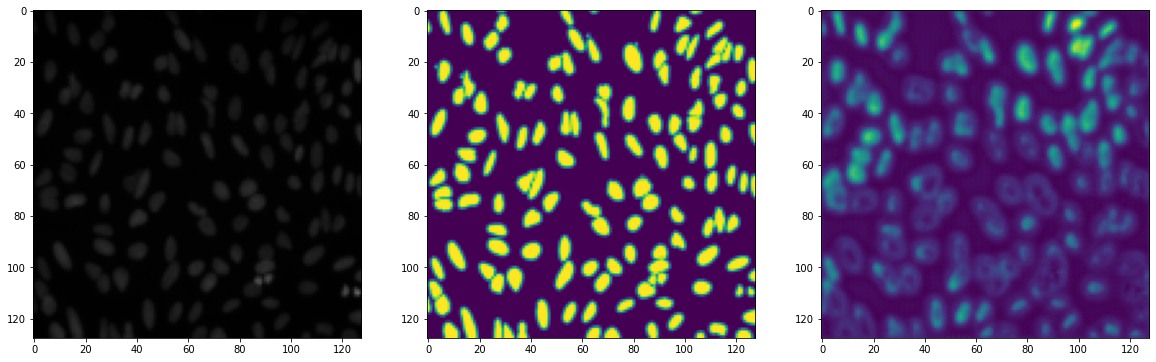

In [47]:
images = imgs[0:1].to(device)
predict_masks = model(images)
print(f"images: {images.shape}, masks: {masks.shape}, predict_masks: {predict_masks.shape}")

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(images[0].permute(1, 2, 0).cpu())
plt.subplot(1,3,2)
plt.imshow(masks[0].permute(1, 2, 0).cpu())
plt.subplot(1,3,3)
plt.imshow(predict_masks[0].permute(1, 2, 0).detach().cpu().numpy())




# plt.figure(figsize=(20,20))
# for i, (image, mask, predict_mask) in enumerate(zip(images,masks,predict_masks)):
#     plt.subplot(10, 3, i*3+1)
#     plt.axis('off')
#     temp = image.clone().cpu()
#     plt.title('image')
#     plt.imshow(temp.permute(1, 2, 0))

#     plt.subplot(10, 3, i*3+2)
#     plt.axis('off')
#     temp = mask.clone().cpu()
#     plt.title('Actual')
#     plt.imshow(temp.squeeze(0))

#     plt.subplot(10, 3, i*3+3)
#     plt.axis('off')
#     temp = predict_mask.clone().cpu()
#     plt.title('Predict')
#     plt.imshow(temp.squeeze(0).detach().numpy())
# plt.show()

# eval of model

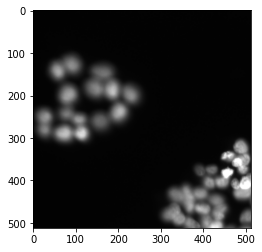

In [8]:
path = "../../Datasets/211202NDA/NDAcquisition-01_XY256.ome.tif"

img = cv2.imread(path)
img = img[100:612,100:612,:]
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img,(512,512))
plt.imshow(img)

In [25]:
# weights_path = '../../Datasets/weights/mask_rcnn_kaggle_v1.h5'
# weights = torch.load(weights_path)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model.load_state_dict(torch.load(weights_path))

In [11]:
model.eval()
output = model(transform(img).unsqueeze(0))[0]

print(output["boxes"].shape)
print(output["labels"].shape)
print(output["scores"].shape)
print(output["masks"].shape)

print(output["labels"])
print(output["scores"])

torch.Size([3, 4])
torch.Size([3])
torch.Size([3])
torch.Size([3, 1, 512, 512])
tensor([3, 3, 4])
tensor([0.2665, 0.0968, 0.0851], grad_fn=<IndexBackward0>)


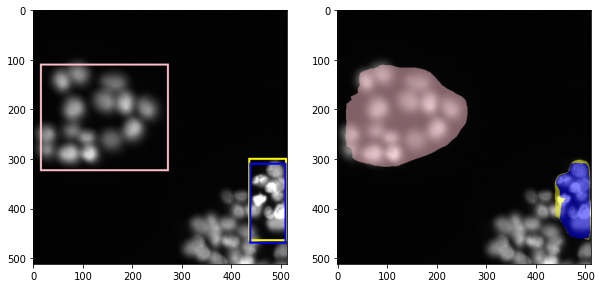

In [23]:
score_threshold = 0.0
backimg = torch.tensor(np.transpose(img,(2,0,1)))
colors = ["yellow","pink","blue"]

boxes = output['boxes'][output['scores'] > score_threshold]
with_boxes = draw_bounding_boxes(backimg, boxes, colors=colors, width=4)

masks = output['masks'][output['scores'] > score_threshold][:,0,:,:].ge(0.5)
with_masks = draw_segmentation_masks(backimg, masks, alpha=0.5, colors=colors)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(with_boxes,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(with_masks,(1,2,0)))

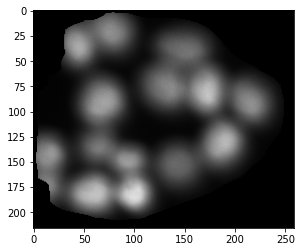

In [38]:
backimg = torch.tensor(np.transpose(img,(2,0,1)))
n = 1
im = backimg.masked_fill_(masks[n]==False, 0)
im = np.transpose(im,(1,2,0))
x1,x2,y1,y2 = int(boxes[n,1].item()),int(boxes[n,3].item()),int(boxes[n,0].item()),int(boxes[n,2].item())
im = im[x1:x2,y1:y2,:]

plt.imshow(im)